In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.stats import linregress
from tqdm import tqdm

This notebook provides an analysis of the error in the optimal tuning approach, and analyzes the distribution of optimally tuned HFX values and how much improvement is expected by a constant shift.

# Mean Absolute Error of Optimal Tuning

In [2]:
tuned = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0')
optimal = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')

print(f'The MAE in HFX% for PBE HS+LS average is {np.mean(np.abs(optimal["hfx_pbe"].clip(0, 100) - (tuned["Tuned LS PBE"].clip(0, 100) + tuned["Tuned HS PBE"].clip(0, 100))/2)):1.2f}.')
print(f'The MAE in HFX% for PBE HS is {np.mean(np.abs(optimal["hfx_pbe"].clip(0, 100) - (tuned["Tuned HS PBE"].clip(0, 100)))):1.2f}.')
print(f'The MAE in HFX% for PBE LS is {np.mean(np.abs(optimal["hfx_pbe"].clip(0, 100) - (tuned["Tuned LS PBE"].clip(0, 100)))):1.2f}.')

print(f'The MAE in HFX% for PBE HS+LS average is {np.mean(np.abs(optimal["hfx_scan"].clip(0, 100) - (tuned["Tuned LS SCAN"].clip(0, 100) + tuned["Tuned HS SCAN"].clip(0, 100))/2)):1.2f}.')
print(f'The MAE in HFX% for PBE HS is {np.mean(np.abs(optimal["hfx_scan"].clip(0, 100) - (tuned["Tuned HS SCAN"].clip(0, 100)))):1.2f}.')
print(f'The MAE in HFX% for PBE LS is {np.mean(np.abs(optimal["hfx_scan"].clip(0, 100) - (tuned["Tuned LS SCAN"].clip(0, 100)))):1.2f}.')

The MAE in HFX% for PBE HS+LS average is 12.26.
The MAE in HFX% for PBE HS is 16.22.
The MAE in HFX% for PBE LS is 10.16.
The MAE in HFX% for PBE HS+LS average is 10.48.
The MAE in HFX% for PBE HS is 14.73.
The MAE in HFX% for PBE LS is 10.52.


In [3]:
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')
tuned['HS+LS Average PBE'] = (tuned['Tuned LS PBE'] + tuned['Tuned HS PBE']) /2
tuned['HS+LS Average SCAN'] = (tuned['Tuned LS SCAN'] + tuned['Tuned HS SCAN']) /2

def pred_energy(structure, functional, target_name):
    #structure is the name of the complex,
    #functional is the functional used, and target_name is the column name.
    df = csd_76
    sse_df = csd_sse_df
    hfx_df = optimal
    pred_hfx = tuned.loc[structure][target_name]
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

d = {'HS+LS Average': ('HS+LS Average PBE', 'HS+LS Average SCAN'),
     'HS': ('Tuned HS PBE', 'Tuned HS SCAN'),
     'LS': ('Tuned LS PBE', 'Tuned LS SCAN')}

hfx_df = optimal
reference_df = csd_76

for key in d:
    pbe_name, scan_name = d[key]
    pbe_errors = []
    scan_errors = []
    
    for struct in tqdm(tuned.index.to_list()):
        reference = reference_df.loc[struct]['dlpno-CCSD_T.vertsse']
        pbe_energy = pred_energy(struct, 'pbe', pbe_name)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', scan_name)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)
    
    print(f'The MAE for {key} PBE is {np.abs(np.array(pbe_errors)).mean():1.2f} kcal/mol.')
    print(f'The MAE for {key} SCAN is {np.abs(np.array(scan_errors)).mean():1.2f} kcal/mol.')

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 185.74it/s]


The MAE for HS+LS Average PBE is 9.01 kcal/mol.
The MAE for HS+LS Average SCAN is 8.00 kcal/mol.


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 181.15it/s]


The MAE for HS PBE is 11.41 kcal/mol.
The MAE for HS SCAN is 10.99 kcal/mol.


100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 182.34it/s]

The MAE for LS PBE is 7.82 kcal/mol.
The MAE for LS SCAN is 7.79 kcal/mol.


# Parity Plots

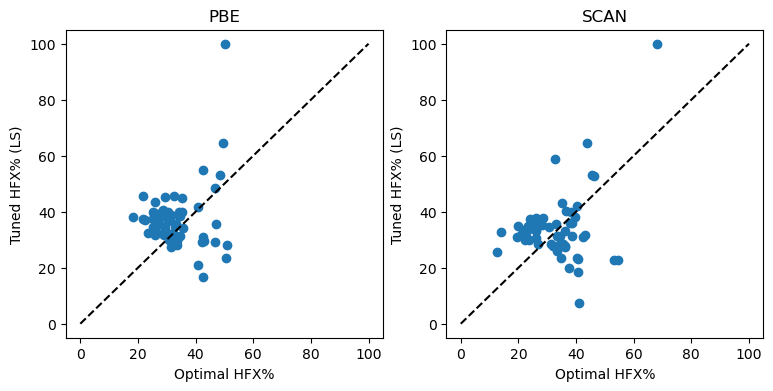

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(9, 4))

ax[0].scatter(optimal['hfx_pbe'].sort_index(), tuned['Tuned LS PBE'].sort_index())
ax[0].set_xlabel('Optimal HFX%')
ax[0].set_ylabel('Tuned HFX% (LS)')
ax[0].set_title('PBE')
ax[0].set_xlim([-5, 105])
ax[0].set_ylim([-5, 105])
ax[0].plot([0, 100], [0, 100], 'k--')

ax[1].scatter(optimal['hfx_scan'].sort_index(), tuned['Tuned LS SCAN'].sort_index())
ax[1].set_xlabel('Optimal HFX%')
ax[1].set_ylabel('Tuned HFX% (LS)')
ax[1].set_title('SCAN')
ax[1].set_xlim([-5, 105])
ax[1].set_ylim([-5, 105])
ax[1].plot([0, 100], [0, 100], 'k--')

# Improvement by a Constant Shift

In [5]:
#subtract off shift from all predictions, see what the minimum error achieved is

def pred_energy(structure, functional, shift):
    df = csd_76
    pred_hfx = tuned.loc[structure]['Tuned LS ' + functional.upper()] - shift
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = csd_sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

def objective(shift, *args):
    functional = args[0]
    pbe_errors = []
    scan_errors = []
    
    for struct in tuned.index.to_list():
        reference = csd_76.loc[struct]['dlpno-CCSD_T.vertsse']
        pbe_energy = pred_energy(struct, 'pbe', shift)
        if pbe_energy is not None:
            pbe_errors.append(reference - pbe_energy)
        scan_energy = pred_energy(struct, 'scan', shift)
        if scan_energy is not None:
            scan_errors.append(reference-scan_energy)
    if functional == 'pbe':
        return np.abs(np.array(pbe_errors)).mean()
    else:
        return np.abs(np.array(scan_errors)).mean()

pbe_min = minimize(objective, 2, args=('pbe'), method='Nelder-Mead')

scan_min = minimize(objective, 2, args=('scan'), method='Nelder-Mead')

print(f'PBE: decrease {pbe_min.x[0]:1.2f} HFX% to reduce error to {pbe_min.fun:1.2f} kcal/mol.')
print(f'SCAN: decrease {scan_min.x[0]:1.2f} HFX% to reduce error to {scan_min.fun:1.2f} kcal/mol.')

PBE: decrease 5.81 HFX% to reduce error to 6.90 kcal/mol.
SCAN: decrease 2.39 HFX% to reduce error to 7.61 kcal/mol.


# Distribution of Tuned HFX Values

HS+LS Average
CSD PBE:
Number of points: 60
Mean: 42.745741526285805
Median: 40.731239318847656
25th Percentile: 38.66539001464844
75th Percentile: 44.60409164428711
CSD SCAN:
Number of points: 55
Mean: 39.29004946621981
Median: 37.70973205566406
25th Percentile: 35.15642166137695
75th Percentile: 40.82071304321289
HS
CSD PBE:
Number of points: 63
Mean: 47.800840347532244
Median: 45.13877868652344
25th Percentile: 41.76471710205078
75th Percentile: 50.55389404296875
CSD SCAN:
Number of points: 61
Mean: 44.781959408619365
Median: 42.37464904785156
25th Percentile: 38.78608703613281
75th Percentile: 48.89205932617188
LS
CSD PBE:
Number of points: 65
Mean: 37.32328796386719
Median: 36.91650390625
25th Percentile: 31.64703369140625
75th Percentile: 39.85679626464844
CSD SCAN:
Number of points: 58
Mean: 34.16377100451239
Median: 32.28302001953125
25th Percentile: 28.49029541015625
75th Percentile: 35.96334457397461


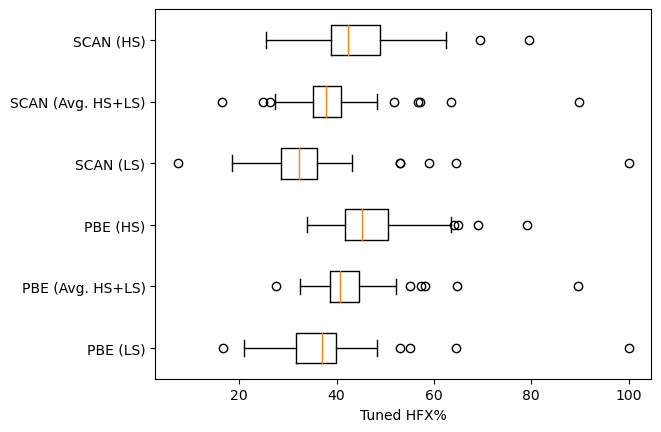

In [6]:
#boxplot of optimal HFX values

#filter out all structures not in CSD-76-HFX
for idx, row in optimal.iterrows():
    if np.isnan(row['hfx_pbe']):
        tuned.loc[idx]['Tuned LS PBE'] = np.nan
        tuned.loc[idx]['Tuned HS PBE'] = np.nan
    if np.isnan(row['hfx_scan']):
        tuned.loc[idx]['Tuned LS SCAN'] = np.nan
        tuned.loc[idx]['Tuned HS SCAN'] = np.nan

avg_csd_pbe = ((tuned['Tuned LS PBE'] + tuned['Tuned HS PBE'])/2).dropna()
avg_csd_scan = ((tuned['Tuned LS SCAN'] + tuned['Tuned HS SCAN'])/2).dropna()
hs_csd_pbe = tuned['Tuned HS PBE'].dropna()
hs_csd_scan = tuned['Tuned HS SCAN'].dropna()
ls_csd_pbe = tuned['Tuned LS PBE'].dropna()
ls_csd_scan = tuned['Tuned LS SCAN'].dropna()

all_hfx = [ls_csd_pbe, avg_csd_pbe, hs_csd_pbe, ls_csd_scan, avg_csd_scan, hs_csd_scan]
labels = ['PBE (LS)', 'PBE (Avg. HS+LS)', 'PBE (HS)', 'SCAN (LS)', 'SCAN (Avg. HS+LS)', 'SCAN (HS)']

fig, ax = plt.subplots()
ax.boxplot(all_hfx, vert=False)
ax.set_yticklabels(labels)
ax.set_xlabel('Tuned HFX%')

for idx, pair in enumerate(([avg_csd_pbe, avg_csd_scan], [hs_csd_pbe, hs_csd_scan], [ls_csd_pbe, ls_csd_scan])):
    if idx == 0:
        print('HS+LS Average')
    elif idx == 1:
        print('HS')
    else:
        print('LS')
    csd_pbe = np.array(pair[0])
    print('CSD PBE:')
    print(f'Number of points: {len(csd_pbe)}')
    print(f'Mean: {csd_pbe.mean()}')
    print(f'Median: {np.median(csd_pbe)}')
    print(f'25th Percentile: {np.percentile(csd_pbe, 25)}')
    print(f'75th Percentile: {np.percentile(csd_pbe, 75)}')
    
    csd_scan = np.array(pair[1])
    print('CSD SCAN:')
    print(f'Number of points: {len(csd_scan)}')
    print(f'Mean: {csd_scan.mean()}')
    print(f'Median: {np.median(csd_scan)}')
    print(f'25th Percentile: {np.percentile(csd_scan, 25)}')
    print(f'75th Percentile: {np.percentile(csd_scan, 75)}')
